In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

set_matplotlib_formats("svg")

In [2]:
import json

from src.paths import external_data

with open(external_data / "mediacloud/protest_news_predicted.jsonl") as f:
    items = [json.loads(line) for line in tqdm(f)]

0it [00:00, ?it/s]

In [3]:
len(items)

20879

In [4]:
climate_items = [i for i in items if "Klima" in i["title"] or "Klima" in i["text"]]
len(climate_items)

1871

Annotation with GPT3.5 would cost 3 euros.
With GPT4 it would be 50 euros, assuming 1000 tokens per text, but maybe that is too high an estimate.

In [5]:
texts = [i["title"] + " " + i["text"] for i in climate_items]
np.median([len(list(i.split())) for i in texts]) * len(texts)

686657.0

Well, ~27 euros with GPT4.

<Axes: xlabel='date'>

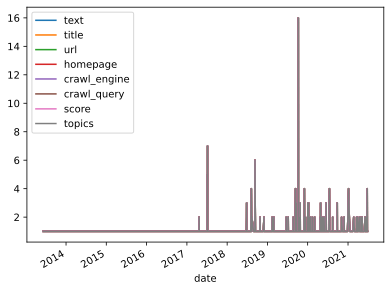

In [6]:
df = pd.DataFrame(climate_items)
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"] <= "2021-06-30"]
df.groupby("date").count().plot()
# plt.xlim("2018-01-01", "2022-06-31")

In [7]:
from src.paths import interim_data

path = interim_data / "german_protest_reports"
labelpath = path / "labels"
labelpath.mkdir(exist_ok=True, parents=True)

schema = """
{
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "IS_CLIMATE_PROTEST_EVENT": {
            "type": "boolean"
        },
        "PAST_OR_FUTURE": {
            "type": "string",
            "enum": ["PAST", "FUTURE"]
        },
        "COUNTRY": {
            "type": "string",
            "enum": ["DE", "AT", "CH", "OTHER"]
        },
        "CITY": {
            "type": "string"
        },
        "PROTEST_DATE_YEAR": {
            "type": "integer"
        },
        "PROTEST_DATE_MONTH": {
            "type": "string",
            "enum": ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        },
        "PROTEST_DATE_DAY": {
            "type": "integer"
        },
        "PROTEST_GROUP": {
            "type": "string",
            "enum": ["FFF", "ALG", "XR", "EG", "GP", "OTHER_CLIMATE_GROUP"]
        },
        "N_PARTICIPANTS": {
            "type": "integer"
        }
        "DESCRIPTION": {
            "type": "string"
        }
    },
    "required": ["IS_CLIMATE_PROTEST_EVENT"]
}
"""

In [8]:
import holidays

from src.data.protests.german_protest_reports.gpt import ask_gpt

system_prompt = f"""
Classify the following text as a climate protest event or not, and - if applicable - fill out the details.
For the DESCRIPTION field, write a one-sentence summary of the event, including the goal of the protest, the protest form, and potential confrontations with the police.
If there are multiple events, create a separate event object for each event.
Use the following schema:

```json{schema}```
"""

holiday_names = [i[0] for i in holidays.Germany(years=range(2018, 2023)).items()]

costs = []
responses = []
for i, row in tqdm(list(df.sample(10, random_state=1).iterrows())):
    # get weekdays and holidays from the weeks before and after the protest
    date_helper_text = ""
    dates = pd.date_range(
        row.date - pd.Timedelta(days=7), row.date + pd.Timedelta(days=7)
    )
    for date in dates:
        # weekday
        date_helper_text += f"{date.strftime('%A')}, "
        # date
        date_helper_text += f"{date.day}. {date.month_name()} {date.year}"
        # holiday
        if date in holidays.Germany(years=range(2018, 2023)):
            date_helper_text += f", {holidays.Germany(years=range(2018, 2023))[date]}"
        date_helper_text += "\n"
    content = date_helper_text + "\n\n"
    content += f"{row.title}\n\n{row.date.date()}\n\n{row.text}"
    content += "\n\n```json\n["
    cost, response = ask_gpt(system_prompt, content)
    costs.append(cost)
    responses.append(response)
print(sum(costs))

  0%|          | 0/10 [00:00<?, ?it/s]

0.027066


In [9]:
for response in responses:
    print(response)
    print()

{
    "IS_CLIMATE_PROTEST_EVENT": true,
    "PAST_OR_FUTURE": "PAST",
    "COUNTRY": "DE",
    "CITY": "Hamburg",
    "PROTEST_DATE_YEAR": 2020,
    "PROTEST_DATE_MONTH": "February",
    "PROTEST_DATE_DAY": 21,
    "PROTEST_GROUP": "FFF",
    "N_PARTICIPANTS": 60000,
    "DESCRIPTION": "Zehntausende Menschen haben am Freitag in Hamburg zusammen mit der schwedischen Klimaaktivistin Greta Thunberg ein Zeichen für einen entschlosseneren Kampf gegen die Erderhitzung gesetzt, forderten politische Initiativen für mehr Klimaschutz, und die Polizei sprach von rund 20.000 Teilnehmern, die Organisatoren von 60.000."
}

{
    "IS_CLIMATE_PROTEST_EVENT": true,
    "PAST_OR_FUTURE": "PAST",
    "COUNTRY": "DE",
    "CITY": "Bielefeld",
    "PROTEST_DATE_YEAR": 2021,
    "PROTEST_DATE_MONTH": "March",
    "PROTEST_DATE_DAY": 27,
    "PROTEST_GROUP": "XR",
    "N_PARTICIPANTS": null,
    "DESCRIPTION": "Extinction Rebellion activists blocked important streets in Bielefeld, resulting in angry reaction

In [10]:
from geopy.geocoders import Nominatim

from src.data import german_region_names

geolocator = Nominatim(user_agent="protest-impact")


def get_region(city):
    coordinates = geolocator.geocode(city + ", Germany")
    return [r for r in german_region_names if r in coordinates.address][0]